In [3]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

C:\Users\ashkm\AppData\Local\Temp\ipykernel_69764\429619021.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
#use to to look at the data for 1 ticker
ticker = yf.Ticker('JPY=X')
df = ticker.history(period = '6mo', interval='1d')
df.head()

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-08-28 00:00:00+01:00,146.531006,146.716003,146.278000,146.531006,0,0.0,0.0
2023-08-29 00:00:00+01:00,146.464005,147.343994,145.852005,146.464005,0,0.0,0.0
2023-08-30 00:00:00+01:00,145.988007,146.522995,145.557999,145.988007,0,0.0,0.0
2023-08-31 00:00:00+01:00,146.098999,146.190994,145.531006,146.098999,0,0.0,0.0
2023-09-01 00:00:00+01:00,145.473007,146.227005,144.481995,145.473007,0,0.0,0.0


In [5]:
# function to format in a useable df, only keeping the date part of datetime to avoid time-caused errors
# also we found that from yfinanve the 'Date' column was actually an index, so converted it to a column
def get_stock_data_to_df(ticker):
    ticker = yf.Ticker(str(ticker))
    df = ticker.history(period = '6mo', interval='1d')
    df.reset_index(inplace=True)
    df["timestamp_processed"] = [e.strftime('%Y-%m-%d') for e in df["Date"]]
    return df

# making the data stionary to fit the assumption. logging the price for the column given and taking the diffence
# created a new column for that called 'stationary'
def stationaryize(df : pd.DataFrame, time) -> pd.DataFrame:
    df['stationary'] = (np.log(df[time])).diff()
    df = df.dropna(how = 'any', axis = 0, )
    return df


def get_clean_data(ticker, time) -> pd.DataFrame:
    return stationaryize(get_stock_data_to_df(ticker.upper()), time)


# main function here which takes in 2 tickers and the open/close/high/low column, and merges the stationary columnms for each on the timestamp column

def merge_df(ticker1, ticker2, open_or_close):
    df1 = get_clean_data(ticker1, open_or_close)
    # print("df of  " + ticker1 + " " + str(np.shape(df1)))
    # print("df of " + ticker1)
    # print(df1.head())
    df2 = get_clean_data(ticker2, open_or_close)
    # print("df of  " + ticker2 + " " + str(np.shape(df2)))
    # print("df of " + ticker2)
    # print(df2.head())
    # return pd.merge(df1[['stationary']], df2[['stationary']], left_index=True, right_index=True, how='right').rename(columns={'stationary_x': ticker1, 'stationary_y': ticker2}).dropna(how='any')
    return pd.merge(df1[['timestamp_processed', 'stationary']], df2[['timestamp_processed', 'stationary']], on='timestamp_processed', how='right').rename(columns = {'stationary_x': ticker1, 'stationary_y': ticker2}).dropna(how='any')


In [6]:
merge_df('^TNX', '^GSPC', 'Close')

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,timestamp_processed,^TNX,^GSPC
0,2023-08-29,-0.021599,0.014404
1,2023-08-30,-0.000971,0.003826
2,2023-08-31,-0.006089,-0.001598
3,2023-09-01,0.019357,0.001798
4,2023-09-05,0.022510,-0.004203
...,...,...,...
119,2024-02-20,-0.004667,-0.006023
120,2024-02-21,0.011628,0.001263
121,2024-02-22,0.000462,0.020903
122,2024-02-23,-0.015605,0.000348


In [7]:
# function for the granger test. takes in the tickers, time(open/close/high/low), and lag, and calls merge_df function. returns the test


def granger_causality(ticker1, ticker2, time, lag):
    df = merge_df(ticker1, ticker2, time)
    # if len(df[ticker1]) != len(df[ticker2]):
    # minrows = min(len(df[ticker1]), len(df[ticker2]))
    # df = df.iloc[:,:minrows]
    #print(np.shape(df))
    return grangercausalitytests(df[[ticker1, ticker2]], lag)

In [8]:
granger_causality('TSLA', 'AAPL', 'Open', 4)

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1899  , p=0.2775  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2197  , p=0.2694  , df=1
likelihood ratio test: chi2=1.2137  , p=0.2706  , df=1
parameter F test:         F=1.1899  , p=0.2775  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0251  , p=0.3619  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.1379  , p=0.3434  , df=2
likelihood ratio test: chi2=2.1194  , p=0.3466  , df=2
parameter F test:         F=1.0251  , p=0.3619  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4144  , p=0.7430  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=1.3196  , p=0.7245  , df=3
likelihood ratio test: chi2=1.3124  , p=0.7262  , df=3
parameter F test:         F=0.4144  , p=0.7430  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4832  , p=0.7480  

{1: ({'ssr_ftest': (1.18991337202179, 0.27753249857577295, 120.0, 1),
   'ssr_chi2test': (1.2196612063223349, 0.26942715065488076, 1),
   'lrtest': (1.2136538395791376, 0.27060969375137467, 1),
   'params_ftest': (1.1899133720218145, 0.27753249857577594, 120.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.0251427815994871, 0.36194458691806497, 117.0, 2),
   'ssr_chi2test': (2.1379046043613235, 0.34336807501538613, 2),
   'lrtest': (2.1193884914466707, 0.34656175687172, 2),
   'params_ftest': (1.025142781599496, 0.36194458691806036, 117.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.4144055434605751, 0.7429770281570186, 114.0, 3),
   'ssr_chi2test': (1.3195544936507786, 0.7244949888951173, 3),
   'lrtest': (1.3124112393829819, 0.7261880358024336, 3),
   'params_ftest': (0.414405543460594, 0.7429770281570061, 114.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.,

In [9]:
granger_causality('^TNX', '^GSPC', 'Close', 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0640  , p=0.8007  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0656  , p=0.7978  , df=1
likelihood ratio test: chi2=0.0656  , p=0.7979  , df=1
parameter F test:         F=0.0640  , p=0.8007  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2749  , p=0.0413  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=6.8297  , p=0.0329  , df=2
likelihood ratio test: chi2=6.6454  , p=0.0361  , df=2
parameter F test:         F=3.2749  , p=0.0413  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7076  , p=0.0485  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=8.6215  , p=0.0348  , df=3
likelihood ratio test: chi2=8.3282  , p=0.0397  , df=3
parameter F test:         F=2.7076  , p=0.0485  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0541  , p=0.0917  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


{1: ({'ssr_ftest': (0.06401272682270631, 0.8006954335380561, 120.0, 1),
   'ssr_chi2test': (0.06561304499327397, 0.7978346797197604, 1),
   'lrtest': (0.06559555092303526, 0.797861048436457, 1),
   'params_ftest': (0.06401272682269271, 0.8006954335380764, 120.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.274888057601406, 0.04131598309980075, 117.0, 2),
   'ssr_chi2test': (6.829681077390967, 0.03288164963422522, 2),
   'lrtest': (6.645362635452898, 0.036056024369081084, 2),
   'params_ftest': (3.2748880576014083, 0.04131598309980075, 117.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.707566578832429, 0.04854785592024153, 114.0, 3),
   'ssr_chi2test': (8.621462001019049, 0.034771033172953866, 3),
   'lrtest': (8.328167002951659, 0.03969470479773607, 3),
   'params_ftest': (2.707566578832427, 0.04854785592024153, 114.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.

In [10]:
granger_causality("amx", 'aapl', 'Close', 7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5454  , p=0.4616  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.5590  , p=0.4547  , df=1
likelihood ratio test: chi2=0.5578  , p=0.4552  , df=1
parameter F test:         F=0.5454  , p=0.4616  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6531  , p=0.5223  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.3620  , p=0.5061  , df=2
likelihood ratio test: chi2=1.3544  , p=0.5080  , df=2
parameter F test:         F=0.6531  , p=0.5223  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6390  , p=0.5914  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.0347  , p=0.5652  , df=3
likelihood ratio test: chi2=2.0178  , p=0.5687  , df=3
parameter F test:         F=0.6390  , p=0.5914  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8877  , p=0.4738  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


{1: ({'ssr_ftest': (0.5453918917450398, 0.461648629899147, 120.0, 1),
   'ssr_chi2test': (0.5590266890386657, 0.45465267034121115, 1),
   'lrtest': (0.5577601558627521, 0.45516412012716456, 1),
   'params_ftest': (0.5453918917450518, 0.46164862989914146, 120.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.6530698267919408, 0.5223322336816865, 117.0, 2),
   'ssr_chi2test': (1.3619575874977228, 0.5061213614202, 2),
   'lrtest': (1.354411530408015, 0.5080345788062316, 2),
   'params_ftest': (0.6530698267919383, 0.52233223368169, 117.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.63899702539935, 0.5914333914413661, 114.0, 3),
   'ssr_chi2test': (2.034701054561088, 0.5652356994064653, 3),
   'lrtest': (2.0177829781544006, 0.5687239971273903, 3),
   'params_ftest': (0.6389970253993371, 0.5914333914413714, 114.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0.,

In [11]:
# def get_all_tickers(client) -> list[str]:
#     response = client.get_snapshot_all('stocks')
#     tickers = [i.ticker for i in response]
#     return tickers
# def get_test_results():
#     tickers = get_all_tickers(client)
#     all_correlations = [[-1 for i in range(len(tickers) - 1)] for j in range(len(tickers) - 1)]
#     all_trials = len(tickers) * (len(tickers) - 1) // 2
#     success = 0
#     for ticker1 in range(len(tickers) - 1):
#         for ticker2 in range(ticker1 + 1, len(tickers) - 1):
#             print(f'{success} / {all_trials} done')
#             t1 = tickers[ticker1]
#             t2 = tickers[ticker2]
#             try:
#                 merged = merge_df(t1, t2,'close')
#                 test = grangercausalitytests(merged[[t1, t2]], 7)
#                 best_corr = max(test, key = lambda x: x[1][0]['ssr_ftest'][1])
#                 success += 1
#             except:
#                 continue
#             all_correlations[ticker1][ticker2] = best_corr[0]
#     return all_correlations

In [12]:
# # %pip install matplotlib
# import matplotlib.pyplot as plt
# print("getting all data correlations")
# all_correlations = get_test_results()
# print("done getting all correlations")
# plt.imshow(a, cmap='hot', interpolation='nearest')
# plt.show()
# plt.savefig('./big_correlation_map')

In [13]:
ticker_lst = ['aapl', 'goog', 'amd', 'nvda', 'are', 'amx', 'cof', 'cvx', 'f', 'ma']

In [14]:
def get_matrix_data(tickers):
    correlations = [[-1 for i in range(len(tickers))] for j in range(len(tickers))]
    for i in range(len(tickers)):
        for j in range(len(tickers)):
            if i != j:
                correlations[i][j] = max(granger_causality(tickers[i], tickers[j], 'Close', 1).items(), key = lambda x: x[1])
                
    return correlations[0][1][1][0]['ssr_ftest'][1]        

In [ ]:
results = granger_causality('aapl','tsla', 'Close', 4)
f_stats = []
for lag in results.keys():
    f_statistic = results[lag][0]['ssr_ftest'][0]
    f_stats.append(f_statistic)
print(max(f_stats))

In [26]:
corr_fstats = []

for i in ticker_lst:
    f_stats = []
    for j in ticker_lst:
        if i != j:
            results = granger_causality(i, j, "Close", 4)
            max_f_statistic = max([results[lag][0]['ssr_ftest'][0] for lag in results.keys()])
            f_stats.append(max_f_statistic)
    corr_fstats.append(f_stats)


C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0005  , p=0.9820  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0005  , p=0.9818  , df=1
likelihood ratio test: chi2=0.0005  , p=0.9818  , df=1
parameter F test:         F=0.0005  , p=0.9820  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3279  , p=0.7211  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.6839  , p=0.7104  , df=2
likelihood ratio test: chi2=0.6820  , p=0.7111  , df=2
parameter F test:         F=0.3279  , p=0.7211  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3636  , p=0.7794  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=1.1577  , p=0.7632  , df=3
likelihood ratio test: chi2=1.1522  , p=0.7645  , df=3
parameter F test:         F=0.3636  , p=0.7794  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3604  , p=0.8363  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1501  , p=0.6991  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.1539  , p=0.6948  , df=1
likelihood ratio test: chi2=0.1538  , p=0.6949  , df=1
parameter F test:         F=0.1501  , p=0.6991  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3528  , p=0.7035  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.7357  , p=0.6922  , df=2
likelihood ratio test: chi2=0.7335  , p=0.6930  , df=2
parameter F test:         F=0.3528  , p=0.7035  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3117  , p=0.8169  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.9925  , p=0.8031  , df=3
likelihood ratio test: chi2=0.9885  , p=0.8040  , df=3
parameter F test:         F=0.3117  , p=0.8169  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3985  , p=0.8093  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1436  , p=0.7054  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.1472  , p=0.7013  , df=1
likelihood ratio test: chi2=0.1471  , p=0.7014  , df=1
parameter F test:         F=0.1436  , p=0.7054  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8613  , p=0.4253  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.7963  , p=0.4073  , df=2
likelihood ratio test: chi2=1.7832  , p=0.4100  , df=2
parameter F test:         F=0.8613  , p=0.4253  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4764  , p=0.6993  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=1.5170  , p=0.6783  , df=3
likelihood ratio test: chi2=1.5076  , p=0.6805  , df=3
parameter F test:         F=0.4764  , p=0.6993  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3778  , p=0.8241  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0504  , p=0.8228  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0517  , p=0.8202  , df=1
likelihood ratio test: chi2=0.0516  , p=0.8202  , df=1
parameter F test:         F=0.0504  , p=0.8228  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2357  , p=0.2944  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.5770  , p=0.2757  , df=2
likelihood ratio test: chi2=2.5502  , p=0.2794  , df=2
parameter F test:         F=1.2357  , p=0.2944  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7574  , p=0.5203  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.4117  , p=0.4915  , df=3
likelihood ratio test: chi2=2.3880  , p=0.4959  , df=3
parameter F test:         F=0.7574  , p=0.5203  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5843  , p=0.6746  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2311  , p=0.0419  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=4.3368  , p=0.0373  , df=1
likelihood ratio test: chi2=4.2621  , p=0.0390  , df=1
parameter F test:         F=4.2311  , p=0.0419  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1184  , p=0.1248  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.4179  , p=0.1098  , df=2
likelihood ratio test: chi2=4.3398  , p=0.1142  , df=2
parameter F test:         F=2.1184  , p=0.1248  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5299  , p=0.2106  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.8714  , p=0.1815  , df=3
likelihood ratio test: chi2=4.7759  , p=0.1890  , df=3
parameter F test:         F=1.5299  , p=0.2106  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4499  , p=0.2224  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8780  , p=0.1731  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.9250  , p=0.1653  , df=1
likelihood ratio test: chi2=1.9101  , p=0.1670  , df=1
parameter F test:         F=1.8780  , p=0.1731  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4058  , p=0.2493  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.9317  , p=0.2309  , df=2
likelihood ratio test: chi2=2.8971  , p=0.2349  , df=2
parameter F test:         F=1.4058  , p=0.2493  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3940  , p=0.0721  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=7.6229  , p=0.0545  , df=3
likelihood ratio test: chi2=7.3924  , p=0.0604  , df=3
parameter F test:         F=2.3940  , p=0.0721  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7748  , p=0.1389  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0431  , p=0.8358  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0442  , p=0.8334  , df=1
likelihood ratio test: chi2=0.0442  , p=0.8335  , df=1
parameter F test:         F=0.0431  , p=0.8358  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2823  , p=0.7546  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.5887  , p=0.7450  , df=2
likelihood ratio test: chi2=0.5873  , p=0.7455  , df=2
parameter F test:         F=0.2823  , p=0.7546  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1817  , p=0.3199  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=3.7629  , p=0.2882  , df=3
likelihood ratio test: chi2=3.7056  , p=0.2951  , df=3
parameter F test:         F=1.1817  , p=0.3199  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0297  , p=0.3952  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu

likelihood ratio test: chi2=3.3929  , p=0.3349  , df=3
parameter F test:         F=1.0806  , p=0.3603  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8570  , p=0.4923  , df_denom=111, df_num=4
ssr based chi2 test:   chi2=3.7058  , p=0.4473  , df=4
likelihood ratio test: chi2=3.6497  , p=0.4555  , df=4
parameter F test:         F=0.8570  , p=0.4923  , df_denom=111, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8081  , p=0.3705  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.8283  , p=0.3628  , df=1
likelihood ratio test: chi2=0.8255  , p=0.3636  , df=1
parameter F test:         F=0.8081  , p=0.3705  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5835  , p=0.2096  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=3.3024  , p=0.1918  , df=2
likelihood ratio test: chi2=3.2585  , p=0.1961  , df=2
parameter F test:         F=1.5835  , p

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0585  , p=0.8092  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0600  , p=0.8065  , df=1
likelihood ratio test: chi2=0.0600  , p=0.8065  , df=1
parameter F test:         F=0.0585  , p=0.8092  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0344  , p=0.9662  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.0718  , p=0.9647  , df=2
likelihood ratio test: chi2=0.0718  , p=0.9648  , df=2
parameter F test:         F=0.0344  , p=0.9662  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1331  , p=0.9402  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.4237  , p=0.9353  , df=3
likelihood ratio test: chi2=0.4230  , p=0.9355  , df=3
parameter F test:         F=0.1331  , p=0.9402  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5679  , p=0.6865  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2033  , p=0.6529  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.2083  , p=0.6481  , df=1
likelihood ratio test: chi2=0.2082  , p=0.6482  , df=1
parameter F test:         F=0.2033  , p=0.6529  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1684  , p=0.8452  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.3512  , p=0.8390  , df=2
likelihood ratio test: chi2=0.3507  , p=0.8392  , df=2
parameter F test:         F=0.1684  , p=0.8452  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2653  , p=0.2897  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.0290  , p=0.2583  , df=3
likelihood ratio test: chi2=3.9634  , p=0.2654  , df=3
parameter F test:         F=1.2653  , p=0.2897  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9267  , p=0.4512  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2038  , p=0.6525  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.2089  , p=0.6476  , df=1
likelihood ratio test: chi2=0.2087  , p=0.6478  , df=1
parameter F test:         F=0.2038  , p=0.6525  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1027  , p=0.9025  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.2141  , p=0.8985  , df=2
likelihood ratio test: chi2=0.2139  , p=0.8986  , df=2
parameter F test:         F=0.1027  , p=0.9025  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1688  , p=0.9172  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.5376  , p=0.9106  , df=3
likelihood ratio test: chi2=0.5364  , p=0.9108  , df=3
parameter F test:         F=0.1688  , p=0.9172  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5837  , p=0.6751  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu

ssr based F test:         F=2.4368  , p=0.1212  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.4977  , p=0.1140  , df=1
likelihood ratio test: chi2=2.4727  , p=0.1158  , df=1
parameter F test:         F=2.4368  , p=0.1212  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4948  , p=0.0336  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=7.2882  , p=0.0261  , df=2
likelihood ratio test: chi2=7.0788  , p=0.0290  , df=2
parameter F test:         F=3.4948  , p=0.0336  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4293  , p=0.0689  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=7.7354  , p=0.0518  , df=3
likelihood ratio test: chi2=7.4982  , p=0.0576  , df=3
parameter F test:         F=2.4293  , p=0.0689  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7393  , p=0.1464  , df_denom=111, df_num=4
ssr based chi2 test: 

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0879  , p=0.2990  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.1151  , p=0.2910  , df=1
likelihood ratio test: chi2=1.1101  , p=0.2921  , df=1
parameter F test:         F=1.0879  , p=0.2990  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6129  , p=0.5435  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.2781  , p=0.5278  , df=2
likelihood ratio test: chi2=1.2715  , p=0.5296  , df=2
parameter F test:         F=0.6129  , p=0.5435  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3908  , p=0.7599  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=1.2443  , p=0.7424  , df=3
likelihood ratio test: chi2=1.2380  , p=0.7439  , df=3
parameter F test:         F=0.3908  , p=0.7599  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5432  , p=0.7043  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0540  , p=0.3067  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.0803  , p=0.2986  , df=1
likelihood ratio test: chi2=1.0756  , p=0.2997  , df=1
parameter F test:         F=1.0540  , p=0.3067  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5498  , p=0.5785  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.1466  , p=0.5637  , df=2
likelihood ratio test: chi2=1.1412  , p=0.5652  , df=2
parameter F test:         F=0.5498  , p=0.5785  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4706  , p=0.7034  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=1.4983  , p=0.6827  , df=3
likelihood ratio test: chi2=1.4891  , p=0.6848  , df=3
parameter F test:         F=0.4706  , p=0.7034  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2017  , p=0.3142  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2903  , p=0.5910  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.2976  , p=0.5854  , df=1
likelihood ratio test: chi2=0.2972  , p=0.5856  , df=1
parameter F test:         F=0.2903  , p=0.5910  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2135  , p=0.3009  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.5307  , p=0.2821  , df=2
likelihood ratio test: chi2=2.5048  , p=0.2858  , df=2
parameter F test:         F=1.2135  , p=0.3009  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2090  , p=0.3098  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=3.8497  , p=0.2782  , df=3
likelihood ratio test: chi2=3.7898  , p=0.2851  , df=3
parameter F test:         F=1.2090  , p=0.3098  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9710  , p=0.4265  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2973  , p=0.5866  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.3047  , p=0.5810  , df=1
likelihood ratio test: chi2=0.3043  , p=0.5812  , df=1
parameter F test:         F=0.2973  , p=0.5866  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6413  , p=0.5285  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.3374  , p=0.5124  , df=2
likelihood ratio test: chi2=1.3301  , p=0.5142  , df=2
parameter F test:         F=0.6413  , p=0.5285  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4468  , p=0.2329  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.6070  , p=0.2029  , df=3
likelihood ratio test: chi2=4.5215  , p=0.2104  , df=3
parameter F test:         F=1.4468  , p=0.2329  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1121  , p=0.3545  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2540  , p=0.6152  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.2603  , p=0.6099  , df=1
likelihood ratio test: chi2=0.2601  , p=0.6101  , df=1
parameter F test:         F=0.2540  , p=0.6152  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7555  , p=0.4721  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.5755  , p=0.4549  , df=2
likelihood ratio test: chi2=1.5654  , p=0.4572  , df=2
parameter F test:         F=0.7555  , p=0.4721  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5454  , p=0.6522  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=1.7367  , p=0.6288  , df=3
likelihood ratio test: chi2=1.7243  , p=0.6315  , df=3
parameter F test:         F=0.5454  , p=0.6522  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8236  , p=0.5128  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4385  , p=0.5091  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.4495  , p=0.5026  , df=1
likelihood ratio test: chi2=0.4487  , p=0.5030  , df=1
parameter F test:         F=0.4385  , p=0.5091  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3889  , p=0.0962  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9819  , p=0.0828  , df=2
likelihood ratio test: chi2=4.8829  , p=0.0870  , df=2
parameter F test:         F=2.3889  , p=0.0962  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9706  , p=0.1224  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=6.2747  , p=0.0990  , df=3
likelihood ratio test: chi2=6.1175  , p=0.1060  , df=3
parameter F test:         F=1.9706  , p=0.1224  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7855  , p=0.1368  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0372  , p=0.8473  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0382  , p=0.8451  , df=1
likelihood ratio test: chi2=0.0382  , p=0.8451  , df=1
parameter F test:         F=0.0372  , p=0.8473  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0596  , p=0.9421  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1244  , p=0.9397  , df=2
likelihood ratio test: chi2=0.1243  , p=0.9397  , df=2
parameter F test:         F=0.0596  , p=0.9421  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7959  , p=0.4986  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.5343  , p=0.4691  , df=3
likelihood ratio test: chi2=2.5081  , p=0.4738  , df=3
parameter F test:         F=0.7959  , p=0.4986  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.0421  , p=0.0009  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5581  , p=0.4565  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.5721  , p=0.4494  , df=1
likelihood ratio test: chi2=0.5707  , p=0.4500  , df=1
parameter F test:         F=0.5581  , p=0.4565  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8827  , p=0.4164  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.8409  , p=0.3983  , df=2
likelihood ratio test: chi2=1.8271  , p=0.4011  , df=2
parameter F test:         F=0.8827  , p=0.4164  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6913  , p=0.5592  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.2013  , p=0.5317  , df=3
likelihood ratio test: chi2=2.1816  , p=0.5356  , df=3
parameter F test:         F=0.6913  , p=0.5592  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5468  , p=0.7017  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0306  , p=0.8615  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0313  , p=0.8595  , df=1
likelihood ratio test: chi2=0.0313  , p=0.8595  , df=1
parameter F test:         F=0.0306  , p=0.8615  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0884  , p=0.9155  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1843  , p=0.9120  , df=2
likelihood ratio test: chi2=0.1841  , p=0.9121  , df=2
parameter F test:         F=0.0884  , p=0.9155  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6586  , p=0.5792  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.0971  , p=0.5525  , df=3
likelihood ratio test: chi2=2.0791  , p=0.5562  , df=3
parameter F test:         F=0.6586  , p=0.5792  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7501  , p=0.5600  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4043  , p=0.1236  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.4644  , p=0.1164  , df=1
likelihood ratio test: chi2=2.4401  , p=0.1183  , df=1
parameter F test:         F=2.4043  , p=0.1236  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5769  , p=0.0122  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=9.5450  , p=0.0085  , df=2
likelihood ratio test: chi2=9.1900  , p=0.0101  , df=2
parameter F test:         F=4.5769  , p=0.0122  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0720  , p=0.0306  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=9.7818  , p=0.0205  , df=3
likelihood ratio test: chi2=9.4065  , p=0.0243  , df=3
parameter F test:         F=3.0720  , p=0.0306  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5005  , p=0.0465  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5957  , p=0.4417  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.6106  , p=0.4346  , df=1
likelihood ratio test: chi2=0.6091  , p=0.4351  , df=1
parameter F test:         F=0.5957  , p=0.4417  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9468  , p=0.3909  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.9745  , p=0.3726  , df=2
likelihood ratio test: chi2=1.9586  , p=0.3756  , df=2
parameter F test:         F=0.9468  , p=0.3909  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6870  , p=0.5618  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.1875  , p=0.5344  , df=3
likelihood ratio test: chi2=2.1680  , p=0.5383  , df=3
parameter F test:         F=0.6870  , p=0.5618  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6166  , p=0.6516  

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu

ssr based F test:         F=22.2677 , p=0.0000  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=22.8244 , p=0.0000  , df=1
likelihood ratio test: chi2=20.9369 , p=0.0000  , df=1
parameter F test:         F=22.2677 , p=0.0000  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.0930 , p=0.0001  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=21.0486 , p=0.0000  , df=2
likelihood ratio test: chi2=19.4179 , p=0.0001  , df=2
parameter F test:         F=10.0930 , p=0.0001  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.9751  , p=0.0002  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=22.2102 , p=0.0001  , df=3
likelihood ratio test: chi2=20.3913 , p=0.0001  , df=3
parameter F test:         F=6.9751  , p=0.0002  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.6158  , p=0.0004  , df_denom=111, df_num=4
ssr based chi2 test: 

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu

ssr based F test:         F=0.5896  , p=0.4441  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.6044  , p=0.4369  , df=1
likelihood ratio test: chi2=0.6029  , p=0.4375  , df=1
parameter F test:         F=0.5896  , p=0.4441  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2223  , p=0.1129  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.6345  , p=0.0985  , df=2
likelihood ratio test: chi2=4.5486  , p=0.1029  , df=2
parameter F test:         F=2.2223  , p=0.1129  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6246  , p=0.1876  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=5.1730  , p=0.1596  , df=3
likelihood ratio test: chi2=5.0655  , p=0.1671  , df=3
parameter F test:         F=1.6246  , p=0.1876  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4143  , p=0.2339  , df_denom=111, df_num=4
ssr based chi2 test: 

C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\ashkm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a fu

In [27]:
print(corr_fstats)

[[0.3635859778026355, 0.5451675288959137, 0.3985489802550977, 0.8613259473078068, 1.235705937882892, 0.6729062232230004, 4.231059929304402, 2.393956649776012, 0.3300918645667918], [1.1817450299198773, 0.6319640377694182, 2.1795022409486955, 0.6353955381112022, 1.8064610122998368, 0.4554770929990525, 1.4426350990425336, 1.6164140408156107, 1.1177426066268534], [0.9129904507861752, 0.5678636786747618, 2.028338205836909, 0.9724099845700568, 0.29058964076690785, 0.6890327411430909, 1.379552689098674, 1.2653119513674203, 0.7046803057205998], [0.40480329974383233, 0.38853254715583163, 1.1605194438210238, 0.9599008321158807, 0.6914104276526238, 0.5836598961447157, 0.31494921557102284, 1.9183033652759751, 3.494767343554651], [2.6507352969316007, 0.6129097284895899, 1.6248786436763014, 1.0879030475658005, 4.320703832380878, 4.659282535154677, 0.3978563243939488, 1.2016871002977956, 3.014598990784198], [0.8877319176444236, 1.2118440915355153, 1.2134785554124725, 0.7579665988543732, 1.06001265339

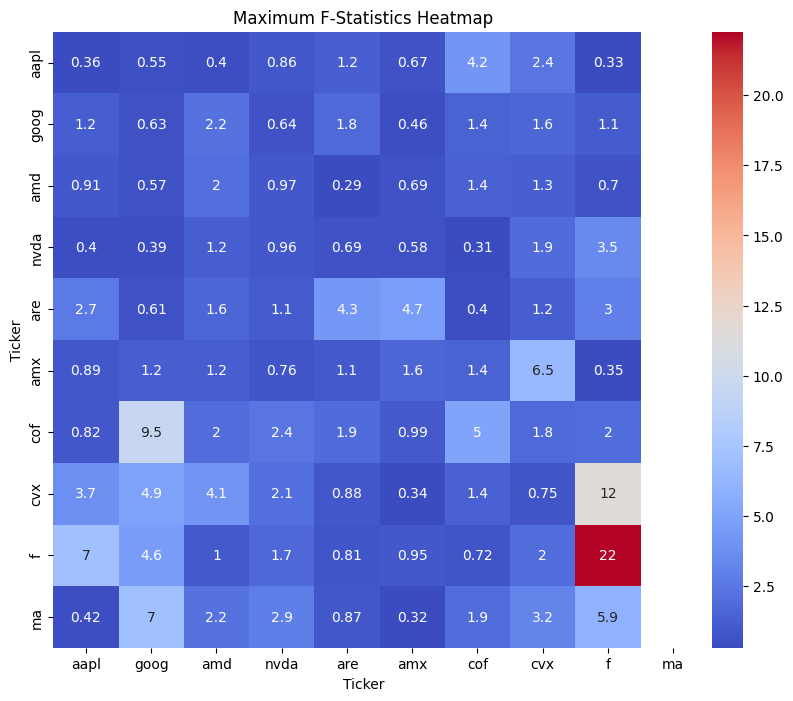

In [28]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(corr_fstats, annot=True, cmap="coolwarm", xticklabels=ticker_lst, yticklabels=ticker_lst)
plt.xlabel("Ticker")
plt.ylabel("Ticker")
plt.title("Maximum F-Statistics Heatmap")
plt.show()